# Import the relevant libraries

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from copy import deepcopy

# Load the image into a numpy array

In [83]:
path_to_jpg_file = "/content/sample_data/5.jpeg"
img = mpimg.imread(path_to_jpg_file)

In [84]:
img.shape

(1000, 1600, 3)

# Display the image

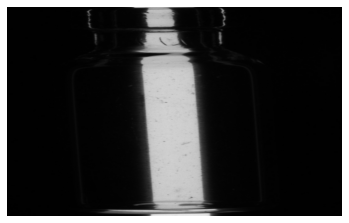

In [85]:
plt.imshow(img)
plt.axis('off')
plt.show()

# Reshape the image

In [86]:
pixels = img.reshape((-1,3))

In [87]:
pixels.shape

(1600000, 3)

In [88]:
pixels[0]

array([1, 1, 1], dtype=uint8)

# Implement agglomerative clustering from scratch

In [89]:
def euclidean_distance(point1, point2):
    """
    Computes euclidean distance of point1 and point2.
    
    point1 and point2 are lists.
    """
    return np.linalg.norm(np.array(point1) - np.array(point2))

def clusters_distance(cluster1, cluster2):
    """
    Computes distance between two clusters.
    
    cluster1 and cluster2 are lists of lists of points
    """
    return max([euclidean_distance(point1, point2) for point1 in cluster1 for point2 in cluster2])
  
def clusters_distance_2(cluster1, cluster2):
    """
    Computes distance between two centroids of the two clusters
    
    cluster1 and cluster2 are lists of lists of points
    """
    cluster1_center = np.average(cluster1, axis=0)
    cluster2_center = np.average(cluster2, axis=0)
    return euclidean_distance(cluster1_center, cluster2_center)


class AgglomerativeClustering:
    
    def __init__(self, k=2, initial_k=25):
        self.k = k
        self.initial_k = initial_k
        
    def initial_clusters(self, points):
        """
        partition pixels into self.initial_k groups based on color similarity
        """
        groups = {}
        d = int(256 / (self.initial_k))
        for i in range(self.initial_k):
            j = i * d
            groups[(j, j, j)] = []
        for i, p in enumerate(points):
            if i%100000 == 0:
                print('processing pixel:', i)
            go = min(groups.keys(), key=lambda c: euclidean_distance(p, c))  
            groups[go].append(p)
        return [g for g in groups.values() if len(g) > 0]
        
    def fit(self, points):

        # initially, assign each point to a distinct cluster
        print('Computing initial clusters ...')
        self.clusters_list = self.initial_clusters(points)
        print('number of initial clusters:', len(self.clusters_list))
        print('merging clusters ...')

        while len(self.clusters_list) > self.k:

            # Find the closest (most similar) pair of clusters
            cluster1, cluster2 = min([(c1, c2) for i, c1 in enumerate(self.clusters_list) for c2 in self.clusters_list[:i]],
                 key=lambda c: clusters_distance_2(c[0], c[1]))

            # Remove the two clusters from the clusters list
            self.clusters_list = [c for c in self.clusters_list if c != cluster1 and c != cluster2]

            # Merge the two clusters
            merged_cluster = cluster1 + cluster2

            # Add the merged cluster to the clusters list
            self.clusters_list.append(merged_cluster)

            print('number of clusters:', len(self.clusters_list))
        
        print('assigning cluster num to each point ...')
        self.cluster = {}
        for cl_num, cl in enumerate(self.clusters_list):
            for point in cl:
                self.cluster[tuple(point)] = cl_num
                
        print('Computing cluster centers ...')
        self.centers = {}
        for cl_num, cl in enumerate(self.clusters_list):
            self.centers[cl_num] = np.average(cl, axis=0)
                    


    def predict_cluster(self, point):
        """
        Find cluster number of point
        """
        # assuming point belongs to clusters that were computed by fit functions
        return self.cluster[tuple(point)]

    def predict_center(self, point):
        """
        Find center of the cluster that point belongs to
        """
        point_cluster_num = self.predict_cluster(point)
        center = self.centers[point_cluster_num]
        return center

# Clustering for k=2

In [90]:
n_clusters = 4
agglo = AgglomerativeClustering(k=n_clusters, initial_k=25)
agglo.fit(pixels)

Computing initial clusters ...
processing pixel: 0
processing pixel: 100000
processing pixel: 200000
processing pixel: 300000
processing pixel: 400000
processing pixel: 500000
processing pixel: 600000
processing pixel: 700000
processing pixel: 800000
processing pixel: 900000
processing pixel: 1000000
processing pixel: 1100000
processing pixel: 1200000
processing pixel: 1300000
processing pixel: 1400000
processing pixel: 1500000
number of initial clusters: 25
merging clusters ...
number of clusters: 24
number of clusters: 23
number of clusters: 22
number of clusters: 21
number of clusters: 20
number of clusters: 19
number of clusters: 18
number of clusters: 17
number of clusters: 16
number of clusters: 15
number of clusters: 14
number of clusters: 13
number of clusters: 12
number of clusters: 11
number of clusters: 10
number of clusters: 9
number of clusters: 8
number of clusters: 7
number of clusters: 6
number of clusters: 5
number of clusters: 4
assigning cluster num to each point ...

### Create the clustered image and plot it

In [91]:
new_img = [[agglo.predict_center(list(pixel)) for pixel in row] for row in img]
new_img = np.array(new_img, np.uint8)

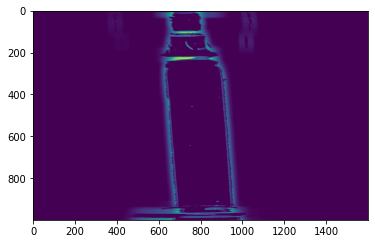

In [92]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
blur = cv2.blur(gray,(71,71))

diff = cv2.subtract(blur, gray)
#ret, th = cv2.threshold(diff, 13, 255, cv2.THRESH_BINARY_INV)
#cv2.imshow("threshold", th)
#cv2.waitKey(0)
plt.imshow(diff)
plt.show()



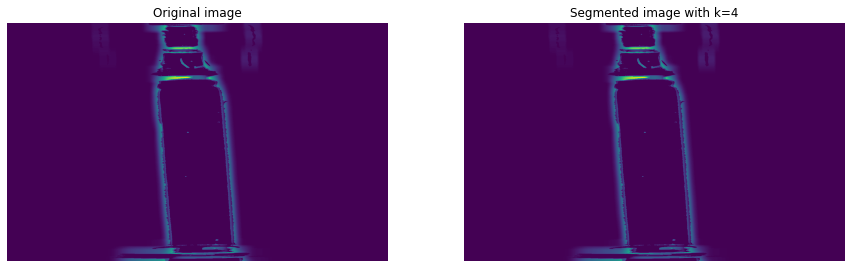

In [93]:
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.imshow(diff)
plt.axis('off')
plt.title('Original image')

plt.subplot(1,2,2)
plt.imshow(diff)
plt.axis('off')
plt.title(f'Segmented image with k={n_clusters}')

plt.show()

Detect possible number of deffective spots on vail

In [94]:
import cv2
gray = diff

## threshold
th, threshed = cv2.threshold(gray, 100, 255,cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)

## findcontours
cnts = cv2.findContours(threshed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2]


## filter by area
s1= 3
s2 = 20
xcnts = []
for cnt in cnts:
    if s1<cv2.contourArea(cnt) <s2:
        xcnts.append(cnt)

print("possiable number of diffective spots in vail are: {}".format(len(xcnts)))
#Dots number: 23

possiable number of diffective spots in vail are: 17


find the defective area by infill and outline 

<class 'list'>
61


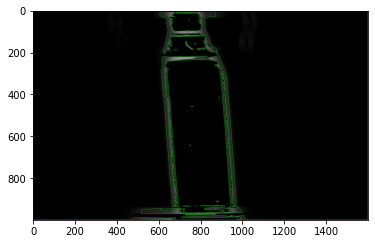

In [95]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils
#path = ''
#path_output = ''

img_bgr = diff
plt.imshow(img_bgr)

# bgr to rgb
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

# Converting to grayscale
img_just_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

# Displaying the grayscale image
plt.imshow(img_just_gray, cmap='gray')

# Gaussian Blur
ksize_w = 13
ksize_h = 13

img_first_gb = cv2.GaussianBlur(img_rgb, (ksize_w,ksize_h), 0, 0, cv2.BORDER_REPLICATE);
plt.imshow(img_first_gb)

# Dilate the image

dilated_img = cv2.dilate(img_first_gb, np.ones((11,11), np.uint8))
plt.imshow(dilated_img)

# Converting to grayscale
img_gray_operated = cv2.cvtColor(dilated_img, cv2.COLOR_BGR2GRAY)

# Displaying the grayscale image
plt.imshow(img_gray_operated, cmap='gray')

# closing:
kernel_closing = np.ones((7,7),np.uint8)
img_closing = cv2.morphologyEx(img_gray_operated, cv2.MORPH_CLOSE, kernel_closing)
plt.imshow(img_closing, cmap='gray')

# dilation:
# add pixels to the boundaries of objects in an image
kernel_dilation = np.ones((3,3),np.uint8)
img_dilation2 = cv2.dilate(img_closing, kernel_dilation, iterations = 1)
plt.imshow(img_dilation2, cmap='gray')

diff_img = 255 - cv2.absdiff(img_just_gray, img_dilation2)
plt.imshow(diff_img, cmap='gray')

# canny
edgesToFindImage = img_dilation2

v = np.median(img_just_gray)
#print(v)
sigma = 0.33
lower_thresh = int(max(0,(1.0-sigma)*v))
higher_thresh = int(min(255,(1.0+sigma)*v))

img_edges =  cv2.Canny(edgesToFindImage, lower_thresh, higher_thresh)
plt.imshow(img_edges, cmap='gray')

kernel_dilation2 = np.ones((2,2),np.uint8)
img_dilation2 = cv2.dilate(img_edges, kernel_dilation, iterations = 2)
plt.imshow(img_dilation2, cmap='gray')

# find contours
contoursToFindImage = img_dilation2

#(_, cnts, _) = cv2.findContours(contoursToFindImage.copy(), cv2.RETR_EXTERNAL,
        #cv2.CHAIN_APPROX_SIMPLE)
print(type(cnts))
print(len(cnts))

# -1 for all
cntsWhichOne = -1 

# -1 for infill
# >0 for edge thickness
cntsInfillOrEdgeThickness = 1 #thickness of defect outline

img_drawing_contours_on_rgb_image = cv2.drawContours(img_rgb.copy(), cnts, cntsWhichOne, (0, 255, 0), cntsInfillOrEdgeThickness)
plt.imshow(img_drawing_contours_on_rgb_image)